## Analyzing the NYC Taxi Data

We will walk through the analysis of New York City Taxi Data using python. 5 months of 'Yellow' label data will be loaded and analyzed.

In [ ]:
pip install pyshp

In [ ]:
# libraries

import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math

#for visualising 
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

### Dataset

We are downloading data from [NYC Taxi and Limousine Commission](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). 

We are using python to download label data from January 2019 to May 2019.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''
import os
path = '/content/drive/My Drive/nyc-project/dataset'

os.chdir(path)
'''

In [ ]:
# need to create a database because huge dataset

from sqlalchemy import create_engine

nyc_taxi_database = create_engine('sqlite:///nyc_taxi_database.db')

In [ ]:
'''
# For downloading data from the website
import requests

for month in range(3,6):
  file_url = "https://s3.amazonaws.com/nyc-tlc/trip+data/" + "yellow_tripdata_2019-{0:0=2d}.csv".format(month)

  path = "/content/drive/My Drive/nyc-project/dataset/yellow_tripdata_2019-{0:0=2d}.csv".format(month)

  r = requests.get(file_url, stream = True)
  with open(path, "wb") as file:
    for block in r.iter_content(chunk_size = 1024):
      if block:
        file.write(block)
  print('{} done'.format(month))'''

'\n# For downloading data from the website\nimport requests\n\nfor month in range(3,6):\n  file_url = "https://s3.amazonaws.com/nyc-tlc/trip+data/" + "yellow_tripdata_2019-{0:0=2d}.csv".format(month)\n\n  path = "/content/drive/My Drive/nyc-project/dataset/yellow_tripdata_2019-{0:0=2d}.csv".format(month)\n\n  r = requests.get(file_url, stream = True)\n  with open(path, "wb") as file:\n    for block in r.iter_content(chunk_size = 1024):\n      if block:\n        file.write(block)\n  print(\'{} done\'.format(month))'

In [ ]:
# Download the location Data

urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip", "taxi_zones.zip")

with zipfile.ZipFile("taxi_zones.zip","r") as zip_ref:
    zip_ref.extractall("./shape")

In [ ]:
df = pd.read_csv("/content/drive/My Drive/nyc-project/dataset/yellow_tripdata_2019-01.csv", nrows=10)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


The columns we need:


*   VendorID
*   tpep_pickup_datetime
*   tpep_dropoff_datetime
*   trip_distance
*   PULocationID
*   DOLocationID
*   total_amount

We also need the pick-up and drop-off coordinates.












In [ ]:
'''
# Now we load the trip record data into our database chunk by chunk.
from time import time

j, chunksize = 1, 100000
for month in range(1,6):
  start = time()
  fp = "/content/drive/My Drive/nyc-project/dataset/yellow_tripdata_2019-{0:0=2d}.csv".format(month)
  for df in pd.read_csv(fp, chunksize=chunksize, iterator=True):
    df = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'total_amount']]
    df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns})
    df['pickup_hour'] = [x[11:13] for x in df['tpep_pickup_datetime']]
    df['dropoff_hour'] = [x[11:13] for x in df['tpep_dropoff_datetime']]
    df.index += j
    df.to_sql('table_record', nyc_taxi_database, if_exists='append')
    j = df.index[-1] + 1
    
  print('{} finished in {} sec'.format(month, (time() - start)))
del df
print('Done')

'''

1 finished in 181.46880269050598 sec
2 finished in 159.19368982315063 sec
3 finished in 177.34056663513184 sec
4 finished in 164.0720992088318 sec
5 finished in 174.924565076828 sec
Done


### Location Data
Location data including TLC taxi zone location IDs, location names and corresponding boroughs for each ID can be found [here](https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv). A shapefile containing the boundaries for the taxi zones can be found [here](https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip).

In [ ]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [ ]:
sf = shapefile.Reader("shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


In [ ]:
df_loc.to_csv('/content/drive/My Drive/nyc-project/dataset/location_data.csv', index = False)

In [ ]:
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [ ]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

In [ ]:
def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

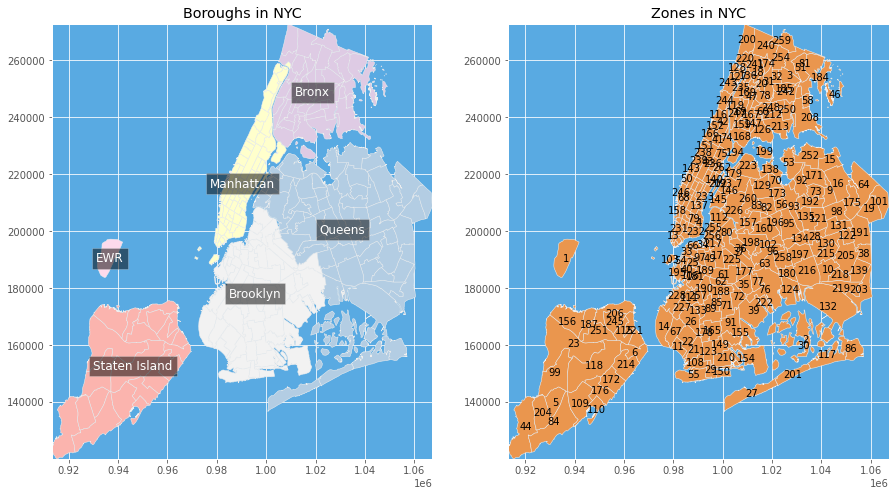

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

### Which regions have most pickups and drop-offs?

In [ ]:
df_pu = pd.read_sql_query('SELECT PULocationID AS LocationID, count(*) AS PUcount \
                        FROM table_record \
                        GROUP BY PULocationID', nyc_taxi_database)
df_do = pd.read_sql_query('SELECT DOLocationID AS LocationID, count(*) AS DOcount \
                        FROM table_record \
                        GROUP BY DOLocationID', nyc_taxi_database)

In [ ]:
template = pd.DataFrame([x for x in range(1,max(df_loc['LocationID'].tolist()))], columns=["LocationID"])
df_q1 = pd.concat([df_pu, df_do]).join(template.set_index("LocationID"), how = 'outer', on=["LocationID"]).fillna(0) \
                                    .groupby(["LocationID"], as_index=False) \
                                    .agg({'PUcount': 'sum', 'DOcount': 'sum'})\
                                    .sort_values(by=['LocationID'])
df_q1['TOTALcount'] = df_q1['PUcount'] + df_q1['DOcount']
loc = df_loc[["LocationID", "zone", "borough"]]
df_q1 = df_q1.merge(loc, left_on="LocationID", right_on="LocationID")

PUcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['PUcount'].tolist()))
PUtop3 = df_q1.sort_values(by=['PUcount'], ascending=False).set_index("LocationID").head(3)
DOcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['DOcount'].tolist()))
DOtop3 = df_q1.sort_values(by=['DOcount'], ascending=False).set_index("LocationID").head(3)

In [ ]:
PUtop3

,PUcount,DOcount,TOTALcount,zone,borough
LocationID,,,,,
237,1615557.0,1447252.0,3062809.0,Upper East Side South,Manhattan
161,1546269.0,1445987.0,2992256.0,Midtown Center,Manhattan
236,1497389.0,1562301.0,3059690.0,Upper East Side North,Manhattan


In [ ]:
DOtop3

,PUcount,DOcount,TOTALcount,zone,borough
LocationID,,,,,
236,1497389.0,1562301.0,3059690.0,Upper East Side North,Manhattan
237,1615557.0,1447252.0,3062809.0,Upper East Side South,Manhattan
161,1546269.0,1445987.0,2992256.0,Midtown Center,Manhattan


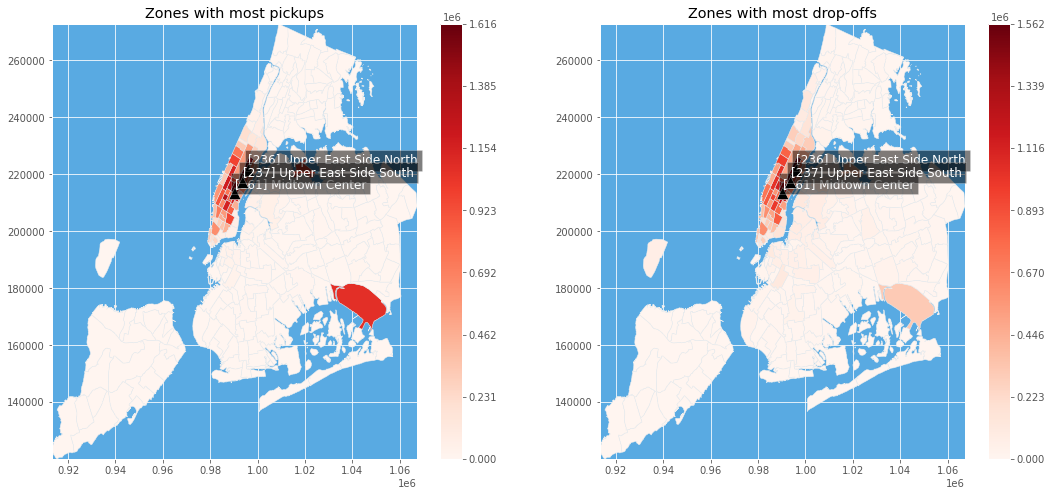

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pickups")
draw_zone_map(ax, sf, heat=PUcount, text=PUtop3.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs")
draw_zone_map(ax, sf, heat=DOcount, text=DOtop3.index.tolist())

In the tables above, we can see that in the first half of 2019,


*   the top 3 pickup zones are Upper East Side South, Midtown Center, and Upper East Side North, which are all in Manhattan.
*   the top 3 drop-off zones are also Upper East Side North, Upper East Side South, and Midtown Center.




In [ ]:
df_q1_region = df_q1.groupby(["borough"], as_index=False) \
                    .agg({'PUcount': 'sum', 'DOcount': 'sum', 'TOTALcount': 'sum'}) \
                    .sort_values(by=['TOTALcount'], ascending=False)
df_q1_region

,borough,PUcount,DOcount,TOTALcount
3,Manhattan,34074271.0,33289076.0,67363347.0
4,Queens,2482692.0,1871759.0,4354451.0
1,Brooklyn,455284.0,1551146.0,2006430.0
0,Bronx,70779.0,263042.0,333821.0
2,EWR,2938.0,68244.0,71182.0
5,Staten Island,1541.0,10058.0,11599.0


In [ ]:
PUcount = dict(zip(df_q1_region['borough'].tolist(), df_q1_region['PUcount'].tolist()))
DOcount = dict(zip(df_q1_region['borough'].tolist(), df_q1_region['DOcount'].tolist()))

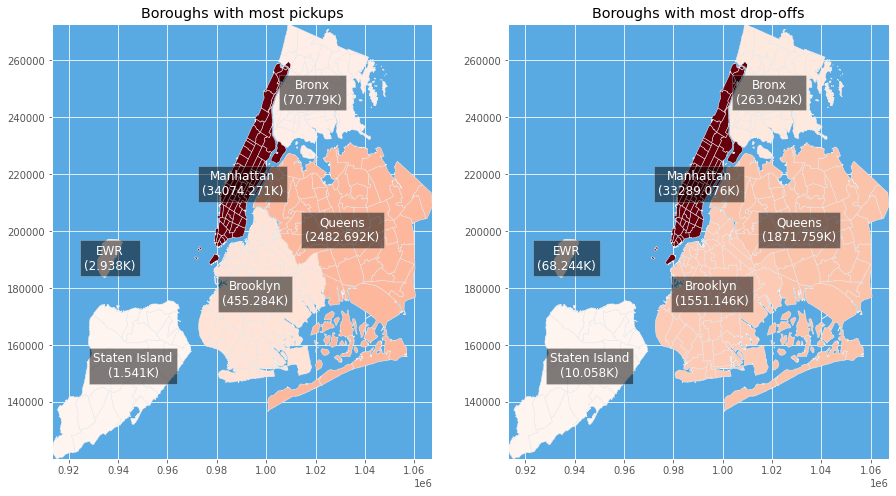

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups")
draw_region_map(ax, sf, heat = PUcount)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most drop-offs")
draw_region_map(ax, sf, heat = DOcount)

In the figure above, it is noticed that in the first half of 2019, there are more pickups in Queens than in Brooklyn while there are similar number of drop-offs in both Queens and Brooklyn.

### When are the peak hours and off-peak hours for taking taxi?

In [ ]:
df_pu = pd.read_sql_query('SELECT pickup_hour AS time, count(*) AS PUcount \
                        FROM table_record \
                        GROUP BY pickup_hour', nyc_taxi_database)
df_do = pd.read_sql_query('SELECT dropoff_hour AS time, count(*) AS DOcount \
                        FROM table_record \
                        GROUP BY dropoff_hour', nyc_taxi_database)
df_q2 = df_pu.merge(df_do, on="time")

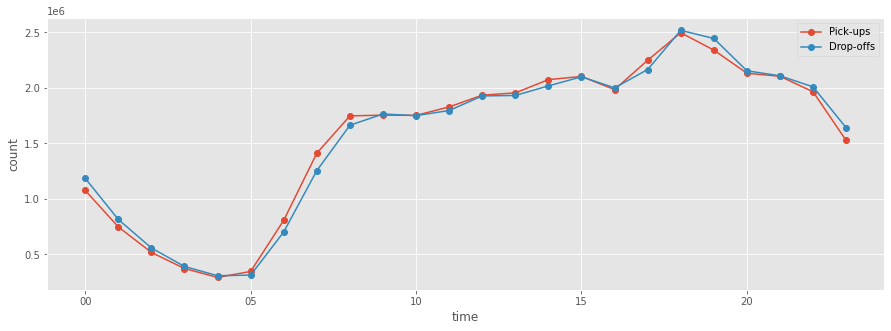

In [ ]:
template = pd.DataFrame(["{0:0=2d}".format(x) for x in range(0,24)], columns=["time"])
df_q2 = df_q2.join(template.set_index("time"), how = 'outer', on=["time"]).fillna(0) \
                .groupby(["time"], as_index=False) \
                .agg({'PUcount': 'sum', 'DOcount': 'sum'}) \
                .rename(columns = {'PUcount':'Pick-ups', 'DOcount': 'Drop-offs'}) \
                .sort_values(by='time')

ax = df_q2.plot(x='time', y=['Pick-ups', 'Drop-offs'], kind='line', style="-o", figsize=(15,5))
ax.set_ylabel("count")
plt.show()

As you can see, according to the NYC Taxi records from 2019 January to 2019 May, it is found that:


*   The peak hours are around 5PM ~ 7PM.
*   The off-peak hours are around 3AM ~ 5AM.

### What are the differences between short and long distance trips of taking taxi?

In [ ]:
df_dist = pd.read_sql_query('SELECT trip_distance FROM table_record', nyc_taxi_database)
df_dist['trip_distance'].describe()

count    3.751811e+07
mean     2.942198e+00
std      3.854664e+00
min      0.000000e+00
25%      9.600000e-01
50%      1.600000e+00
75%      3.000000e+00
max      8.318000e+02
Name: trip_distance, dtype: float64

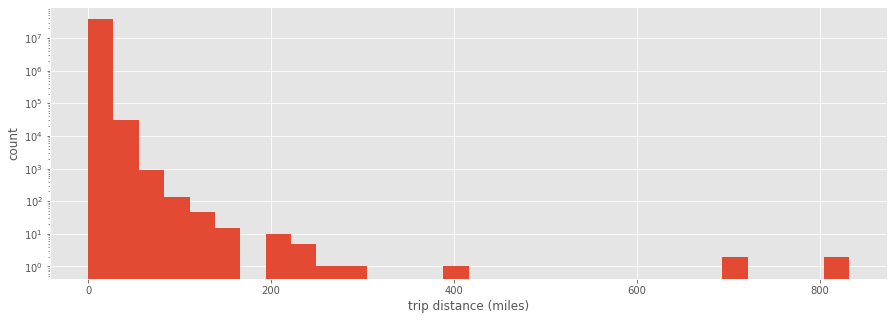

In [ ]:
ax = df_dist['trip_distance'].hist(bins=30, figsize=(15,5))
ax.set_yscale('log')
ax.set_xlabel("trip distance (miles)")
ax.set_ylabel("count")
plt.show()

According to the distribution of trip distances and the fact that it takes about 30 miles to drive across the whole New York City, we decided to use 30 as the number to split the trips into short or long distance trips.

In [ ]:
df_q3_short = pd.read_sql_query('SELECT count(*) AS count FROM table_record \
                                 WHERE trip_distance < 30', nyc_taxi_database)
df_q3_long = pd.read_sql_query('SELECT count(*) AS count FROM table_record \
                                WHERE trip_distance >= 30 ', nyc_taxi_database)
print("Short Trips: {} records in total.\nLong Trips: {} records in total."\
     .format(df_q3_short.values[0][0], df_q3_long.values[0][0]))

Short Trips: 37501096 records in total.
Long Trips: 17016 records in total.
